This notebook is about identifying stroke and swing for tennis sports.

We are using [Myoarm band](https://www.myo.com/) a wearble device to be worn on your fore arm. This device has accelerometer, gyroscope and magnetometer. Along with that it also has eight EMG(Electic Myo graphy) which measues the activity of the muscle, using this it can identify type of gesture created by hand.

We will be using Accelerometer and Gyroscope data to identify the stroke and swing.
Typically acceleremeter data will help us find type of swing played(Topspin, Slice, Serve, Flat .etc) and gyroscope with help us to find fore hand and back hand stroke.

Currently we are only considereing right handed player for the data collection and modelling, but this model should also work for the left handed player but the output/prediction would be totally opposite(Like forehand will be considered as a backhand).

Importing important libraries

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Import data through pandas, 


In [3]:
path = "./data/"
file_name = path + "train_forehand_set1.csv"
forehand_topspin = pd.read_csv(file_name, sep=',',header=0);
file_name = path + "train_backhand_topspin_set2.csv"
backhand_topspin = pd.read_csv(file_name, sep=',',header=0);

forehand_topspin['timestamp'] = (forehand_topspin['timestamp'].diff()/1000)
forehand_topspin['timestamp'][0] = 0
forehand_topspin['timestamp'] = forehand_topspin['timestamp'].cumsum()
forehand_topspin['timestamp'].astype(int)


backhand_topspin['timestamp'] = (backhand_topspin['timestamp'].diff()/1000)
backhand_topspin['timestamp'][0] = 35
backhand_topspin['timestamp'] = backhand_topspin['timestamp'].cumsum()
backhand_topspin['timestamp'].astype(int)




C:\Users\sivab\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sivab\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0             35
1             51
2             72
3             96
4            111
5            140
6            155
7            194
8            196
9            216
10           231
11           256
12           276
13           312
14           322
15           335
16           358
17           373
18           395
19           418
20           433
21           455
22           478
23           493
24           515
25           538
26           553
27           575
28           598
29           613
          ...   
66769    1390364
66770    1390386
66771    1390402
66772    1390423
66773    1390446
66774    1390463
66775    1390484
66776    1390506
66777    1390522
66778    1390547
66779    1390566
66780    1390582
66781    1390605
66782    1390626
66783    1390643
66784    1390663
66785    1390686
66786    1390702
66787    1390723
66788    1390746
66789    1390762
66790    1390785
66791    1390806
66792    1390822
66793    1390853
66794    1390866
66795    1390882
66796    13909

In [4]:
forehand_topspin['stroke'] = "forehand-topspin";
backhand_topspin['stroke'] = "backhand-topspin";
stroke_data = pd.concat([forehand_topspin, backhand_topspin], ignore_index=True)
stroke_y = stroke_data['stroke']


time = stroke_data['timestamp']
gyr = stroke_data[['GyroX', 'GyroY', 'GyroZ']];
acc = stroke_data[['AccX', 'AccY', 'AccZ']] ;
quaternion = stroke_data[['orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']]
#euler = data_file[['roll', 'pitch', 'yaw']]


Given a stream of data from the Myo Device, 
our first goal is to identify the swing is happening or not.

To accomplish this, we came up with the folling algorithm:

1. Normalize the X,Y,Z of accelerometer ( this gives the total G force acting on the device)
2. Pass this Gforce to a butter filter
    1. Butter filter will reduce very high spikes of gforce and increase the low spikes of gforce.
    2. We are creating a tunnel to accept those values which are in between and leave those that are not useful
3. Now we have the filter data, we create a threshold value of 1G, anything above 1G is a swing.
4. We plot the graph to understand the working for the algowithm


In [5]:
def identifyStroke(time, accleration, threshold =1, hpCutOff=.001, 
                   lpCutOff=5.0, sampleFrequecy = 50, number_of_pass = 1, axis=1, plot=True):
    acc_mag= np.sqrt(np.square(accleration).sum(axis=axis))
    b, a =  signal.butter(number_of_pass, 
                          (2*hpCutOff) / sampleFrequecy, 'high', 
                          analog=False)
    hp_filt = signal.filtfilt(b, a, acc_mag)
    hp_filt = np.absolute(hp_filt); 
    b, a = signal.butter(number_of_pass, ((2*lpCutOff)/sampleFrequecy), 'low')
    lp_filt = signal.filtfilt(b, a, hp_filt)
    stationary = lp_filt > threshold;
    if(plot):
        f, (ax1,  ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18,20))
        ax1.plot(time, accleration,)
        ax1.legend(['X','Y','Z'],shadow=True, fancybox=True, loc="upper right");
        
        ax2.plot(time, acc_mag, 'r', label="Magnitude(sqrt(x2+y2+z2))");
        ax2.legend(shadow=True, fancybox=True, loc="upper right");
        
        ax3.plot(time, hp_filt, 'b', label="High Pass Filtered");
        ax3.legend(shadow=True, fancybox=True, loc="upper right");
        
        ax4.plot(time, lp_filt, 'r', label="Low Pass Filtered");
        ax4.plot(time, stationary, 'b', label="Swing");
        ax4.legend(shadow=True, fancybox=True, loc="upper right");
        
    return stationary


def strokeIndexes(time, accleration):
    swingPresent = identifyStroke(time, accleration)
    swing_diff = np.diff(swingPresent+0)
    swingStartIndex = np.where(swing_diff == 1)[0]
    swingEndIndex = np.where(swing_diff == -1)[0]
    swingMidIndex = swingStartIndex + swingEndIndex
    swingMidIndex = np.divide(swingMidIndex,2)
    
    return  swingMidIndex,  swingStartIndex, swingEndIndex, swingPresent


This is helper fucntion which will help to plot different graph on runtime

In [6]:

def plotSwingData(time, gyr, acc, quat, swingPresent, startPos, endPos):
    fig = plt.figure('Position', figsize=(18,10));
    fig.subplots_adjust(hspace=.7)

    plt.subplot(411);
    plt.plot(time[startPos:endPos], gyr[startPos:endPos]);
    #plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m');
    plt.title('Gyroscope');
    plt.xlabel('Time (s)');
    plt.ylabel('Angular velocity (^\circ/s)');
    plt.legend(list(gyr),shadow=True, fancybox=True, loc="upper right");


    plt.subplot(412);
    plt.plot(time[startPos:endPos], acc[startPos:endPos]);
    plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m');
    plt.title('Accelerometer');
    plt.xlabel('Time (s)');
    plt.ylabel('Acceleration (g)');
    plt.legend(list(acc), shadow=True, fancybox=True, loc="upper right");


    plt.subplot(413);
    plt.plot(time[startPos:endPos], quat[startPos:endPos]);
    plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m',);
    plt.title('Quaternions');
    plt.xlabel('Time (s)');
    plt.ylabel('Quaternions');
    plt.legend(list(quaternion), shadow=True, fancybox=True, loc="upper right");



This is about 3d geometery
# Why are we doing this?
We want to show the actual path of the swing in 3d to the player. Using VR Technologies we can play the swing,  using a dummy player and player can visualize the swing.

Quaretion plays a very important role in 3d geometry and it overcomes the problem of gimbla lock. 
Using gyroscope and accelerometer we can find the orientation of the device with quaternions. Myo API has 


In [7]:
def quaternProd(a, b):
    ab = np.zeros(a.shape);
    w, x, y, z = 0, 1, 2, 3
    ab[:,w] = a[:,w]*b[:,w] - a[:,x]*b[:,x] - a[:,y]*b[:,y] - a[:,z]*b[:,z];
    ab[:,x] = a[:,w]*b[:,x] + a[:,x]*b[:,w] + a[:,y]*b[:,z] - a[:,z]*b[:,y];
    ab[:,y] = a[:,w]*b[:,y] - a[:,x]*b[:,z] + a[:,y]*b[:,w] + a[:,z]*b[:,x];
    ab[:,z] = a[:,w]*b[:,z] + a[:,x]*b[:,y] - a[:,y]*b[:,x] + a[:,z]*b[:,w];
    return ab;

def quaternConj(q):
    ab = np.zeros(q.shape);
    w, x, y, z = 0, 1, 2, 3
    ab[:,w] = q[:,w]
    ab[:,x] = -q[:,x]
    ab[:,y] = -q[:,y]
    ab[:,z] = -q[:,z]
    return ab

def quaternRotate(v, q):
    (row, col) = v.shape;
    quaterPoint = np.append(np.zeros((row,1)), v, 1)
    #v0XYZ = quaternProd(quaternProd(q, acc), quaternConj(q));
    v0XYZ = quaternProd(q, quaternProd(quaterPoint, quaternConj(q))); 
    return v0XYZ[:, 1:4];

We are identify swing from the data and plotting the first swing detected!

forehand-topspin


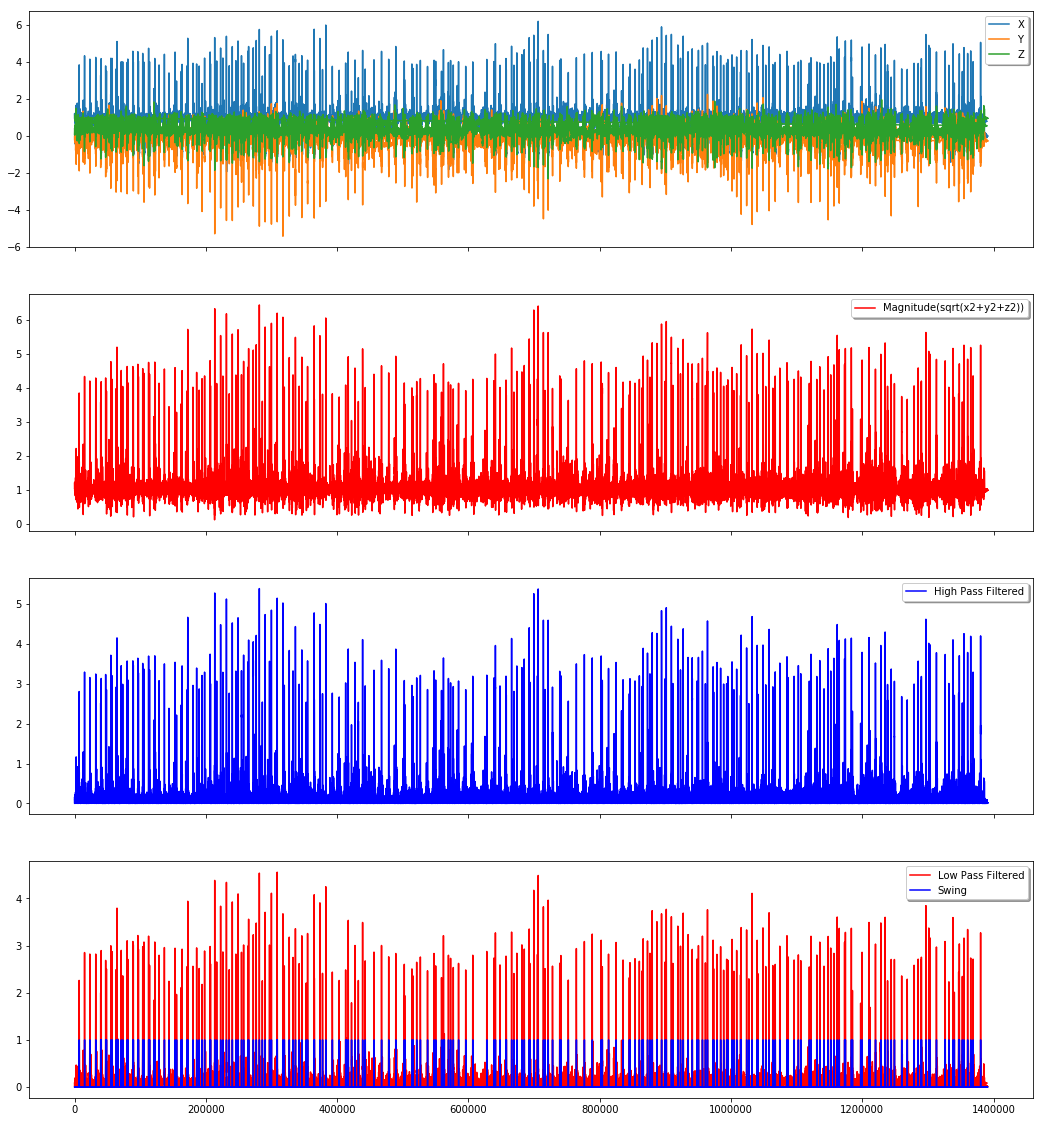

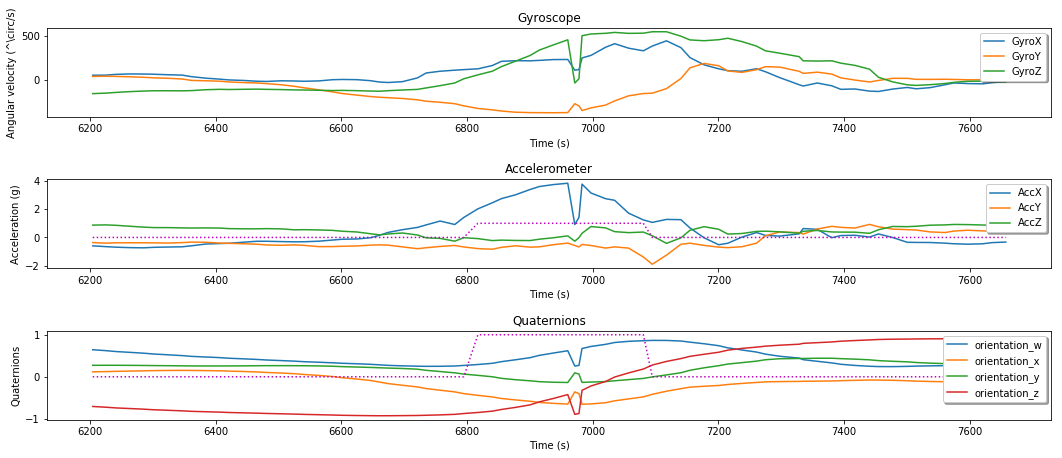

In [8]:

swingMidIndex, swingStartIndex, swingEndIndex, swingPresent = strokeIndexes(time, acc)
startPos = swingStartIndex[0] - 30
endPos = swingEndIndex[0] + 30

print (stroke_y[swingMidIndex[0]])
plotSwingData(time, gyr, acc, quaternion, swingPresent, startPos, endPos )

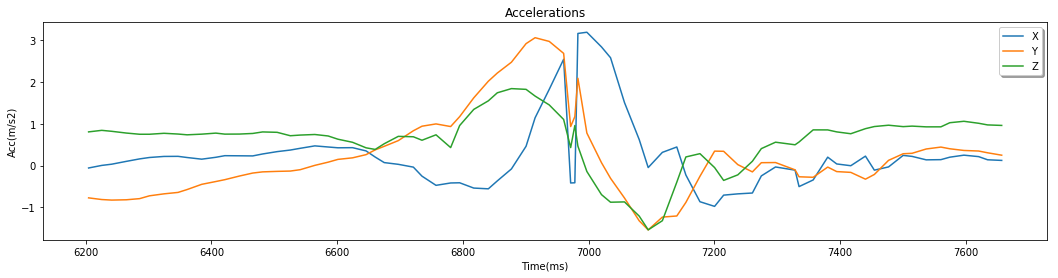

In [9]:
#Compute translational accelerations
def plot_findings(figName, x, y, xlabel, ylabel, legendlabel, figSize=(18,4)):
    plt.figure(figName, figsize=figSize);
    plt.plot(x, y)
    plt.title(figName);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.legend(legendlabel, shadow=True, fancybox=True, loc="upper right");

def cal_tran_acc(time, acc, quat, startPos, endPos,plot=True,):
    accelerometer = acc.copy()
    quat = quat.as_matrix()
    ##Rotate body accelerations to Earth frame
    accelerometer = quaternRotate( accelerometer, quaternConj(quat));
    if(plot):
        plot_findings("Accelerations", time[startPos:endPos], 
                      accelerometer[startPos:endPos], "Time(ms)", "Acc(m/s2)", ('X', 'Y', 'Z'))
    return accelerometer

translation_acc = cal_tran_acc(time, acc,quaternion, startPos, endPos)

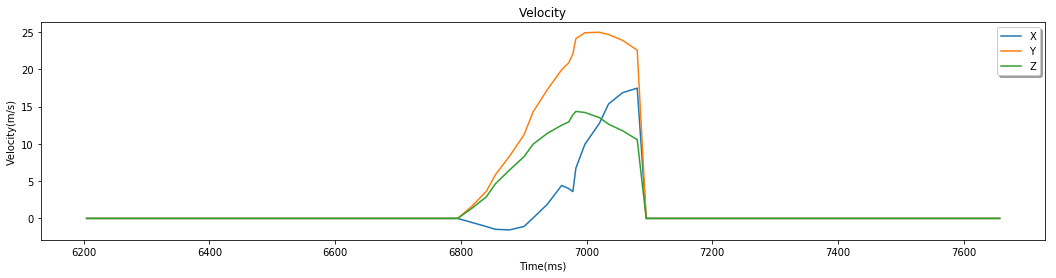

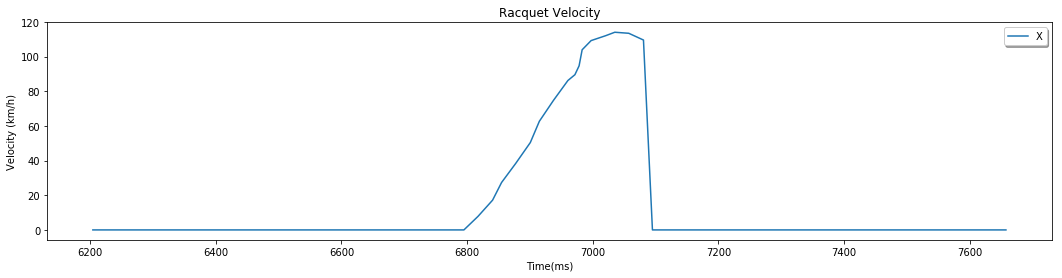

In [10]:
#removing earth's gravity(default ) from z axis

#acc[:,2] = acc[:,2] 9.81;
#samplePeriod = 50;

#Integrate acceleration to yield velocity
vel = np.zeros(translation_acc.shape);
for t in range(1,len(vel)):
    vel[t,:] = vel[t - 1,:] + translation_acc[t,:]# * samplePeriod;
    if(swingPresent[t] == 0):
        vel[t,:] = [0, 0, 0];     # force zero velocity when foot stationary
    
velDrift = np.zeros(vel.shape);
plot_findings("Velocity", time[startPos:endPos], 
                      vel[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))

velocity_norm =  np.linalg.norm(vel, axis=1)
plot_findings("Racquet Velocity", time[startPos:endPos], 
                      velocity_norm[startPos:endPos] * 3.6, "Time(ms)", 'Velocity (km/h)', ('X', 'Y', 'Z'))


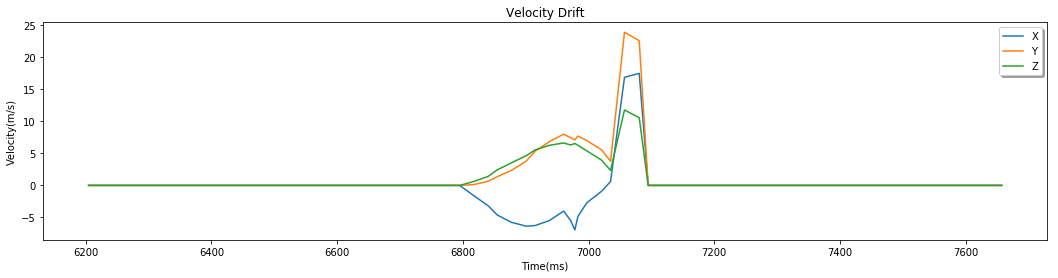

In [11]:

velDrift = np.zeros(vel.shape);
for i in range(0, len(swingEndIndex)):
    rateDiff = (swingEndIndex[i] - swingStartIndex[i])
    driftRate = np.divide(vel[swingEndIndex[i] - 1, :], rateDiff)
    enum = np.arange(0, (swingEndIndex[i] - swingStartIndex[i])-1);
    enum = np.array([enum, enum, enum])
    drift = enum.T * driftRate
    velDrift[swingStartIndex[i]:swingEndIndex[i]-1, :] = drift;

vel = vel - velDrift;             
plot_findings("Velocity Drift", time[startPos:endPos], 
                      vel[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))


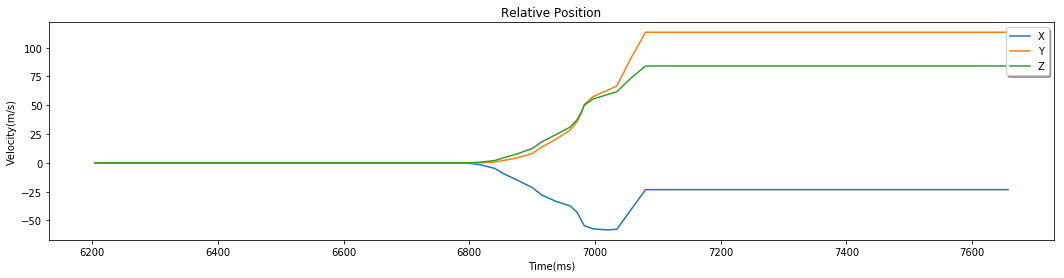

In [12]:
# Compute translational position
# Integrate velocity to yield position


pos = np.zeros(vel.shape);
for t in range(2, len(pos)):
    pos[t] = pos[t-1] + vel[t];    # integrate velocity to yield position
            
plot_findings("Relative Position", time[startPos:endPos], 
                      pos[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))


In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure()
print pos[6,0]
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[300:400,0],pos[300:400,1],pos[300:400, 2])

plt.show()

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(pos[6,0])? (<ipython-input-13-4bdca7ceb506>, line 6)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [57560.0] of <class 'numpy.float64'>

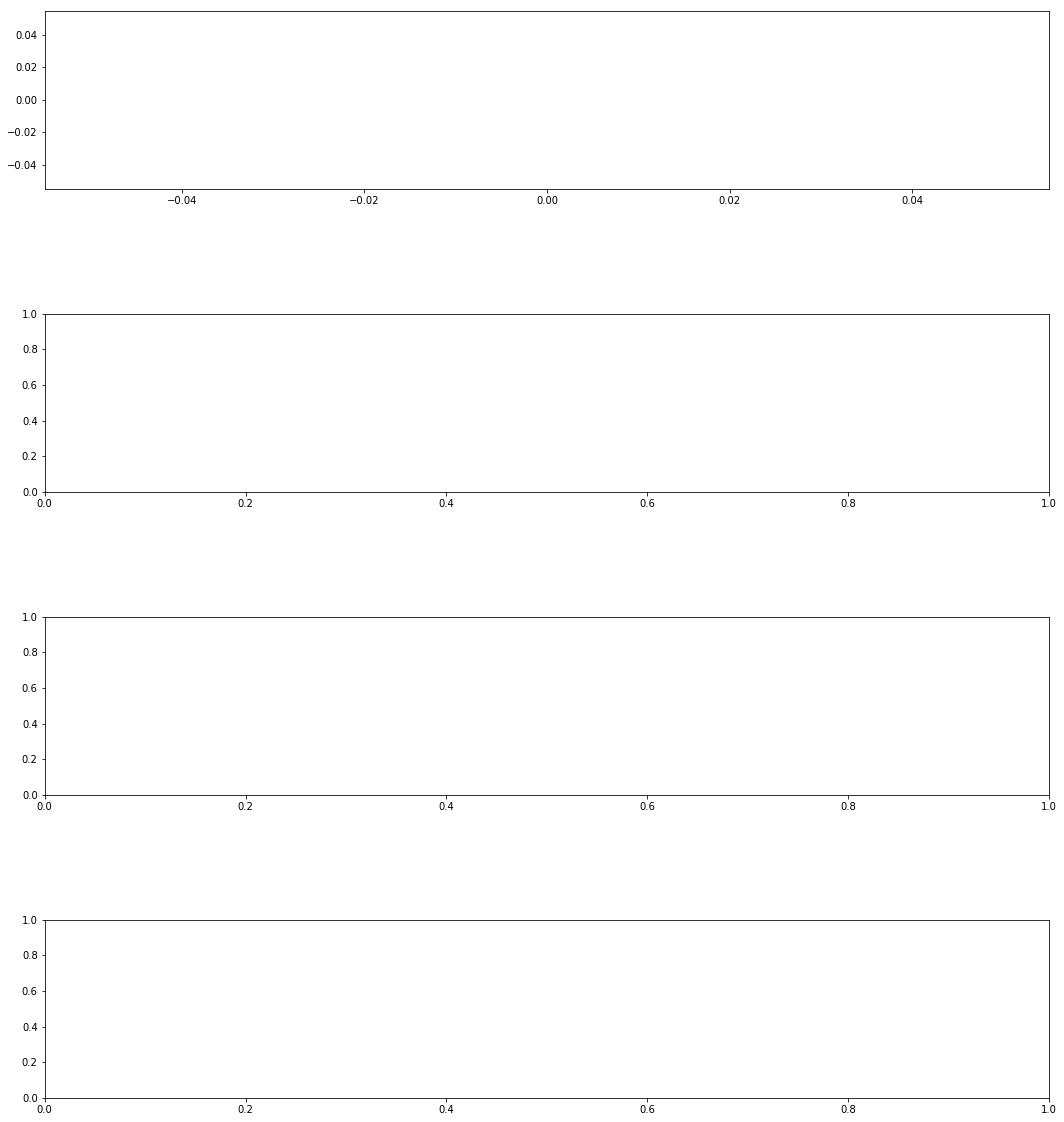

In [14]:
##to do use rolling window to augment data
sample_size = 2;

##to do random sample of 8 swings
sample_index = np.random.randint(0, 133, size=sample_size)
f, axes = plt.subplots(sample_size*2,  figsize=(18,20))
f.subplots_adjust(hspace=.7)
i = 0;
for index in sample_index: 
    si = swingMidIndex[index]
    axes[i].plot()
    axes[i].plot(time[si-25:si+25],acc[si-25:si+25] )
    axes[i].set_title('Swing #  %d' % index);
    axes[i].set_xlabel('Time (s)');
    axes[i].set_ylabel('Angular velocity (^\circ/s)');
    axes[i].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    axes[i+1].plot()
    axes[i+1].plot(time[si-25:si+25],gyr[si-25:si+25] )
    axes[i+1].set_title('Swing #  %d' % index);
    axes[i+1].set_xlabel('Time (s)');
    axes[i+1].set_ylabel('Angular velocity (^\circ/s)');
    axes[i+1].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    i += 2

sample_index = np.random.randint(133, 220, size=sample_size)
f, axes = plt.subplots(sample_size*2,  figsize=(18,20))
f.subplots_adjust(hspace=.7)
i = 0;
for index in sample_index: 
    si = swingMidIndex[index]
    axes[i].plot()
    axes[i].plot(time[si-25:si+25],acc[si-25:si+25] )
    axes[i].set_title('Swing #  %d' % index);
    axes[i].set_xlabel('Time (s)');
    axes[i].set_ylabel('Angular velocity (^\circ/s)');
    axes[i].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    axes[i+1].plot()
    axes[i+1].plot(time[si-25:si+25],gyr[si-25:si+25] )
    axes[i+1].set_title('Swing #  %d' % index);
    axes[i+1].set_xlabel('Time (s)');
    axes[i+1].set_ylabel('Angular velocity (^\circ/s)');
    axes[i+1].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    i += 2

s = []
a = acc[si-25:si+25].as_matrix().T
b = gyr[si-25:si+25].as_matrix().T
z = quaternion[si-25:si+25].as_matrix().T
np.concatenate((a,b), axis=1)
def swingDataAugmenation(swingMidIndex):
    x_features, y_label = [], []
    
    # for each swing generate 50, 3 matrix by sliding 15 data points before and 15 data points after
    #this will give us 30 swings in total each swing. 
    for index in swingMidIndex: 
        Y_value = stroke_y.iloc[index]
        for i in range(20):
            a = acc.iloc[index-25-i:index+25-i].as_matrix().T
            g = gyr.iloc[index-25-i:index+25-i].as_matrix().T
            q = quaternion.iloc[index-25-i:index+25-i].as_matrix().T
            
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
            a = acc.iloc[index-25+i:index+25+i].as_matrix().T
            g = gyr.iloc[index-25+i:index+25+i].as_matrix().T
            q = quaternion.iloc[index-25+i:index+25+i].as_matrix().T
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
    return np.array(x_features), np.array(y_label)

        
def noSwingDataAugmenation(swingMidIndex, Y_value, sample_size=4000):
    x_features, y_label = [], []
    for i in range(0, swingMidIndex.shape[0]-1):
        startIndex = swingMidIndex[i] + 70;
        endIndex = swingMidIndex[i+1] - 70;
        
        while(startIndex<endIndex and endIndex-startIndex > 50):
            a = acc.iloc[startIndex:startIndex + 50].as_matrix().T
            g = gyr.iloc[startIndex:startIndex + 50].as_matrix().T
            q = quaternion.iloc[startIndex:startIndex + 50].as_matrix().T
            y_label.append(Y_value)
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            
            startIndex += 2;
            if(len(x_features) == sample_size):
                return np.array(x_features), np.array(y_label)
    
    return np.array(x_features), np.array(y_label)

trueSwing_X, trueSwing_Y = swingDataAugmenation(swingMidIndex)
falseSwing_X, falseSwing_y = noSwingDataAugmenation(swingMidIndex, "no - swing")
swingDataSet_X = np.concatenate((trueSwing_X, falseSwing_X))
swingDataSet_Y = np.concatenate((trueSwing_Y, falseSwing_y))
print(trueSwing_X.shape, trueSwing_Y.shape)
print(falseSwing_X.shape, falseSwing_y.shape)
    
        


In [16]:
#swingDataSet_Y

#swing_targets = np_utils.to_categorical(swingDataSet_Y, 3)
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
SwingClasses = ["forehand-topspin", "backhand_topspin", "no - swing"]
integer_encoded = label_encoder.fit_transform(swingDataSet_Y)
#1 = forhand
#2 = no swing
#0 = backhand
print integer_encoded
swing_targets = np_utils.to_categorical(integer_encoded, 3)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#swingDataSet_Y = onehot_encoder.fit_transform(integer_encoded)

#print swingDataSet_Y


[1 1 1 ... 2 2 2]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(swingDataSet_X, 
                                        swing_targets, test_size=0.3, 
                                        random_state=1, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                    test_size=0.5, random_state=1)

X_train = np.expand_dims(X_train,4)
X_val = np.expand_dims(X_val,4)
X_test = np.expand_dims(X_test, 4)


print (X_train.shape, X_val.shape, X_test.shape)


((9632, 10, 50, 1), (2064, 10, 50, 1), (2064, 10, 50, 1))


/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # Remove the CWD from sys.path while we load stuff.
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


In [55]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [43]:
model = Sequential()
model.add(Conv2D(16, 2, padding="same", activation='relu', input_shape=(10,50,1)))
model.add(Conv2D(32, 2, activation='relu'))
model.add(Conv2D(64, 2, activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(Dropout(.4))
model.add(Conv2D(256, 3, activation='relu'))
model.add(Dropout(.4))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(3, activation='softmax', kernel_initializer='truncated_normal'))

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 10, 50, 16)        80        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 49, 32)         2080      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 48, 64)         8256      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 46, 128)        73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 46, 128)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 44, 256)        295168    
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 44, 256)        0         
__________

In [44]:
 #X_train, X_test, y_train, y_test
#X_train = X_train.expand_dims(n=4)
trained = model.fit(X_train, y_train, epochs=3, batch_size=30, validation_data=(X_val, y_val),verbose=1)

Train on 9632 samples, validate on 2064 samples
Epoch 1/3
9632/9632 [==============================] - 80s 8ms/step - loss: 0.1626 - acc: 0.9325 - val_loss: 0.0092 - val_acc: 0.9976
Epoch 2/3
9632/9632 [==============================] - 76s 8ms/step - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0186 - val_acc: 0.9927
Epoch 3/3
9632/9632 [==============================] - 75s 8ms/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0028 - val_acc: 0.9990


['acc', 'loss', 'val_acc', 'val_loss']


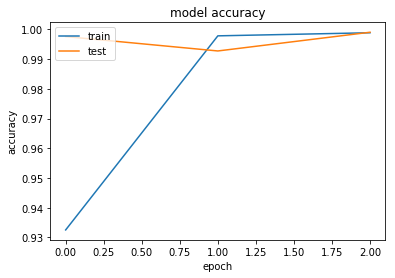

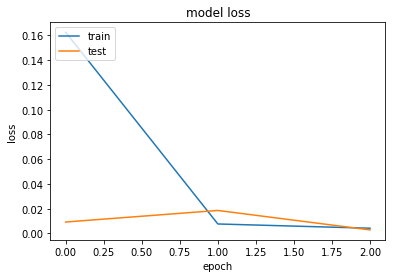

In [45]:
# list all data in history
print(trained.history.keys())
# summarize history for accuracy
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
#
model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, 0))) for test_vector in X_test]
#model_prediction = np.array(model_prediction)
#model_prediction[np.where(model_prediction>=.5)] = 1
#model_prediction[np.where(model_prediction<.5)] = 0
#model_prediction= model_prediction.flatten()
#model_prediction = model_prediction.astype(int)
test_accuracy = 100*np.sum(model_prediction==np.argmax(y_test,axis=1))/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.0000%


In [52]:
b = [node.op.name for node in model.inputs]
##session = K.get_session()
#min_graph = convert_variables_to_constants(session, session.graph_def, [node.op.name for node in model.outputs])


In [53]:
print (b)

[u'conv2d_11_input']


In [56]:


def export_model_for_mobile(model_name, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        model_name + '_graph.pbtxt')

    tf.train.Saver().save(K.get_session(), 'out/' + model_name + '.chkp')

    print (freeze_graph.freeze_graph('out/' + model_name + '_graph.pbtxt', None, \
        False, 'out/' + model_name + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + model_name + '.pb', True, ""))

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + model_name + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/tensorflow_lite_' + model_name + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
        

        
export_model_for_mobile("stroke_prediction", ["conv2d_11_input"], "dense_6/Softmax")

INFO:tensorflow:Restoring parameters from out/stroke_prediction.chkp
INFO:tensorflow:Froze 14 variables.
Converted 14 variables to const ops.
None


In [26]:
file_name = "temp_data/" + "test_shafi_forehand_backhand.csv"
test_file = pd.read_csv(file_name, sep=',',header=0);
#test_file.head()
test_time = test_file['timestamp']
test_acc = test_file[['AccX','AccY', 'AccZ']]
test_gyr = test_file[['GyroX', 'GyroY', 'GyroZ']]
test_quat = test_file[['orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']]
print test_acc.shape
swing_test = []
for i in range(0, test_acc.shape[0]-50, 50):
    a = test_acc[i:i+50].as_matrix().T
    g = test_gyr[i:i+50].as_matrix().T
    q = test_quat[i:i+50].as_matrix().T 
    a = np.concatenate((a,g), axis=0)
    a = np.concatenate((a,q), axis=0)
    swing_test.append(a)

swing_test = np.array(swing_test)

print swing_test.shape
swing_test = np.expand_dims(swing_test,4)
print swing_test.shape  


(809, 3)
(16, 10, 50)
(16, 10, 50, 1)


/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [ ]:
model_prediction = np.array([np.argmax(model.predict(np.expand_dims(test_vector, 0))) for test_vector in swing_test])
print model_prediction
#model_prediction = np.array(model_prediction)
#model_prediction[np.where(model_prediction>=.5)] = 1
#model_prediction[np.where(model_prediction<.5)] = 0
#model_prediction= model_prediction.flatten()
#model_prediction = model_prediction.astype(int)
#test_accuracy = 100*np.sum(model_prediction==y_test)/len(model_prediction)
#print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
swingMidIndex, swingStartIndex, swingEndIndex, swingPresent = strokeIndexes(test_time, test_acc)

print np.where(model_prediction==1)
print swingMidIndex
print swingMidIndex / 50




In [ ]:
fig = plt.figure('Position', figsize=(18,10));
sample_time = test_file['timestamp']
fig.subplots_adjust(hspace=.7)
plt.subplot(411);
plt.plot(sample_time, test_acc);
#plt.plot(time, stationary, 'k', 'LineWidth', 2);
plt.title('Accelerometer');
plt.xlabel('Time (s)');
plt.ylabel('Acceleration (g)');
plt.legend(list(acc), shadow=True, fancybox=True, loc="upper right");



In [ ]:

### this can help us detect the stroke itself.
## need to meet a professor from Electrical Department, who can help us understand this part

#HP filter accelerometer data

filtCutOff = .001;
sampleFrequecy = 50;
number_of_pass = 1
acc_mag = np.sqrt(np.square(test_acc).sum(axis=1))

b, a =  signal.butter(number_of_pass, (2*filtCutOff) / sampleFrequecy, 'high', analog=False)
acc_magFilt = signal.filtfilt(b, a, acc_mag)

f, (ax4, ax1, ax2, ax3) = plt.subplots(4, sharex=True, figsize=(18,20))
ax4.plot(sample_time, acc_mag, 'r', label="Magnitude");

ax1.plot(sample_time, acc_magFilt, 'r', label="High Pass Filtered");

# Compute absolute value
acc_magFilt = np.absolute(acc_magFilt);

# LP filter accelerometer data
filtCutOff = 5.0;
b, a = signal.butter(number_of_pass, (2*(filtCutOff)/ (sampleFrequecy)), 'low')
acc_magFilt = signal.filtfilt(b, a, acc_magFilt)


stationary = acc_magFilt < 1;

ax2.plot(sample_time, acc_magFilt, 'r', label="Low Pass Filtered");
ax2.plot(sample_time, stationary, 'b', label="stationary");

#stationary = acc_magFilt < 0.5; ### this can help us detect the 
ax2.legend(shadow=True, fancybox=True, loc="upper right");



ax3.plot(sample_time, test_acc);

ax3.legend(['X','Y','Z'],shadow=True, fancybox=True, loc="upper right");







In [ ]:
sample_index = np.where(model_prediction==1)[0]
sample_size = len(sample_index)
f, axes = plt.subplots(sample_size,  figsize=(18,400))
f.subplots_adjust(hspace=.7)
backhand = np.squeeze(swing_test, axis=(3,))
i = 0;
for index in sample_index: 
    si = index
    axes[i].plot()
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index,0:3].T )
    i += 1
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index, 3:6].T )
    i += 1
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index, 6:10].T )
    axes[i].set_title('Swing #  %d' % index);
    axes[i].set_xlabel('Time (s)');
    axes[i].set_ylabel('Angular velocity (^\circ/s)');
    axes[i].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    i += 1